<a href="https://colab.research.google.com/github/oatmeelsquares/STAT6021_project2/blob/main/kzk8qq_codeathon_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Codeathon 3:
kzk8qq
Alexandra Ferentinos

In [12]:
import os
import keras_hub
import keras
import zipfile
import tensorflow.data as tf_data
import tensorflow.strings as tf_strings

In [13]:
# Data
BATCH_SIZE = 64
MIN_STRING_LEN = 512  # Strings shorter than this will be discarded
SEQ_LEN = 128  # Length of training sequences, in tokens

# Model
EMBED_DIM = 256
FEED_FORWARD_DIM = 128
NUM_HEADS = 3
NUM_LAYERS = 2
VOCAB_SIZE = 5000  # Limits parameters in model.

# Training
EPOCHS = 5

# Inference
NUM_TOKENS_TO_GENERATE = 80

In [14]:
#Get current working directory
cwd = os.getcwd()

file_path = keras.utils.get_file(
   fname="simplebooks.zip",
   origin="https://dldata-public.s3.us-east-2.amazonaws.com/simplebooks.zip",
   extract=False,
   cache_dir=cwd
)

with zipfile.ZipFile(file_path, 'r') as zip_ref:
   zip_ref.extractall(cwd)

dir = os.path.join(cwd, "simplebooks/")

raw_train_ds = (
   tf_data.TextLineDataset(dir + "simplebooks-92-raw/train.txt")
   .filter(lambda x: tf_strings.length(x) > MIN_STRING_LEN)
   .batch(BATCH_SIZE)
   .shuffle(buffer_size=256)
)

raw_val_ds = (
   tf_data.TextLineDataset(dir + "simplebooks-92-raw/valid.txt")
   .filter(lambda x: tf_strings.length(x) > MIN_STRING_LEN)
   .batch(BATCH_SIZE)
)
print(f"Dataset extracted to: {dir}")

Dataset extracted to: /content/simplebooks/


In [15]:
# Train tokenizer vocabulary
vocab = keras_hub.tokenizers.compute_word_piece_vocabulary(
    raw_train_ds,
    vocabulary_size=VOCAB_SIZE,
    lowercase=True,
    reserved_tokens=["[PAD]", "[UNK]", "[BOS]"],
)

In [16]:
tokenizer = keras_hub.tokenizers.WordPieceTokenizer(
    vocabulary=vocab,
    sequence_length=SEQ_LEN,
    lowercase=True,
)

In [17]:
# packer adds a start token
start_packer = keras_hub.layers.StartEndPacker(
    sequence_length=SEQ_LEN,
    start_value=tokenizer.token_to_id("[BOS]"),
)


def preprocess(inputs):
    outputs = tokenizer(inputs)
    features = start_packer(outputs)
    labels = outputs
    return features, labels


# Tokenize and split into train and label sequences.
train_ds = raw_train_ds.map(preprocess, num_parallel_calls=tf_data.AUTOTUNE).prefetch(
    tf_data.AUTOTUNE
)
val_ds = raw_val_ds.map(preprocess, num_parallel_calls=tf_data.AUTOTUNE).prefetch(
    tf_data.AUTOTUNE
)

In [18]:
inputs = keras.layers.Input(shape=(None,), dtype="int32")
# Embedding.
embedding_layer = keras_hub.layers.TokenAndPositionEmbedding(
    vocabulary_size=VOCAB_SIZE,
    sequence_length=SEQ_LEN,
    embedding_dim=EMBED_DIM,
    mask_zero=True,
)
x = embedding_layer(inputs)
# Transformer decoders.
for _ in range(NUM_LAYERS):
    decoder_layer = keras_hub.layers.TransformerDecoder(
        num_heads=NUM_HEADS,
        intermediate_dim=FEED_FORWARD_DIM,
    )
    x = decoder_layer(x)  # Giving one argument only skips cross-attention.
# Output.
outputs = keras.layers.Dense(VOCAB_SIZE)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
perplexity = keras_hub.metrics.Perplexity(from_logits=True, mask_token_id=0)
model.compile(optimizer="adam", loss=loss_fn, metrics=[perplexity])

In [19]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ token_and_position_embedding         │ (None, None, 256)           │       1,312,768 │
│ (TokenAndPositionEmbedding)          │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_decoder                  │ (None, None, 256)           │         329,085 │
│ (TransformerDecoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_decoder_1                │ (None, None, 256)           │         329,085 │
│ (TransformerDecoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, None, 5000)          │       1,285,000 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,255,938 (12.42 MB)

 Trainable params: 3,255,938 (12.42 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'position_embedding' (of type PositionEmbedding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.

   2445/Unknown 143s 51ms/step - loss: 5.0018 - perplexity: 179.0602

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2445/2445 ━━━━━━━━━━━━━━━━━━━━ 148s 53ms/step - loss: 5.0017 - perplexity: 179.0375 - val_loss: 4.2320 - val_perplexity: 68.9748
Epoch 2/5
2445/2445 ━━━━━━━━━━━━━━━━━━━━ 124s 48ms/step - loss: 4.1723 - perplexity: 64.9344 - val_loss: 4.0926 - val_perplexity: 59.9991
Epoch 3/5
2445/2445 ━━━━━━━━━━━━━━━━━━━━ 124s 48ms/step - loss: 4.0311 - perplexity: 56.3591 - val_loss: 4.0181 - val_perplexity: 55.6350
Epoch 4/5
2445/2445 ━━━━━━━━━━━━━━━━━━━━ 143s 49ms/step - loss: 3.9562 - perplexity: 52.2866 - val_loss: 3.9902 - val_perplexity: 54.1588
Epoch 5/5
2445/2445 ━━━━━━━━━━━━━━━━━━━━ 128s 50ms/step - loss: 3.9137 - perplexity: 50.1147 - val_loss: 3.9818 - val_perplexity: 53.6558


In [21]:
# The "packer" layers adds the [BOS] token for us.
prompt_tokens = start_packer(tokenizer([""]))
prompt_tokens

<tf.Tensor: shape=(1, 128), dtype=int32, numpy=
array([[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
      dtype=int32)>

In [22]:
def next(prompt, cache, index):
    logits = model(prompt)[:, index - 1, :]
    # Ignore hidden states for now; only needed for contrastive search.
    hidden_states = None
    return logits, hidden_states, cache

In [23]:
sampler = keras_hub.samplers.GreedySampler()
output_tokens = sampler(
    next=next,
    prompt=prompt_tokens,
    index=1,  # Start sampling immediately after the [BOS] token.
)
txt = tokenizer.detokenize(output_tokens)
print(f"Greedy search generated text: \n{txt}\n")

Greedy search generated text: 
['[BOS] " i am not going to tell you , " said the boy , " i am not going to tell you that you are not going to be a good one . you are not going to be a good one . you are going to be a good one . you are going to be a good one . you are going to be a good one . you are going to be a good one . you are going to be a good one . you are going to be a good one . you are going to be a good one . you can \' t get a good , and you can \' t get any more . you can \' t']



In [24]:
sampler = keras_hub.samplers.BeamSampler(num_beams=10)
output_tokens = sampler(
    next=next,
    prompt=prompt_tokens,
    index=1,
)
txt = tokenizer.detokenize(output_tokens)
print(f"Beam search generated text: \n{txt}\n")

Beam search generated text: 
['[BOS] " i don \' t know , " said hugh . " i \' m going to tell you what i \' ll do . i \' ll tell you something about it . i don \' t want to tell you about it . i don \' t want to tell you about it . i don \' t want to tell you about it . i don \' t want to tell you about it . i don \' t want to tell you about it . i don \' t like it . i don \' t like it . i don \' t like it . i don \' t like it . i don \' t like it . i don \'']



In [25]:
sampler = keras_hub.samplers.RandomSampler()
output_tokens = sampler(
    next=next,
    prompt=prompt_tokens,
    index=1,
)
txt = tokenizer.detokenize(output_tokens)
print(f"Random search generated text: \n{txt}\n")

Random search generated text: 
['[BOS] " we don \' t know , " mr . gentleman said , eagerly upon which men in the order of be raised . " and your wife told me this man for the purpose and staluting each other . we shall have a large store in place , which we need still stand for the time for having to let olid it . it will be the dry island of our own goods . our resistance was entirely to old , and whom our canoes were sent to emulate yards from bush - footed windows from the rajahginiers , but those who would be repeated again to you , have been too much for the information']



In [26]:
sampler = keras_hub.samplers.TopKSampler(k=10)
output_tokens = sampler(
    next=next,
    prompt=prompt_tokens,
    index=1,
)
txt = tokenizer.detokenize(output_tokens)
print(f"Top-K search generated text: \n{txt}\n")

Top-K search generated text: 
['[BOS] but the little girl felt her little pretensitive about her own age , she was too tired for her . it was so much for the poor , and it were very poor , but she never had a good time for many lessons in the world ; she would never forgive her for it , and it did not seem that it should be a little more . she was a poor old woman . she was a very good , and , as she had not been able to refin from her to the little girl and to her own way . she felt sure she could not be quite alone . she said that she could not understand it']



In [27]:
sampler = keras_hub.samplers.TopPSampler(p=0.5)
output_tokens = sampler(
    next=next,
    prompt=prompt_tokens,
    index=1,
)
txt = tokenizer.detokenize(output_tokens)
print(f"Top-P search generated text: \n{txt}\n")

Top-P search generated text: 
['[BOS] " i \' ll tell you what we can do , " replied the mother . " it \' s only the old woman who \' s had to be a brig , but the children are all gone by . we \' ll go to the house and keep the children , \' she says , \' i \' m a little out of her hand , \' i am in the house , but she is a very old , and i \' ll see you \' ll never be in the world , and i \' ll let her fall , and the best thing for you to have her , she can \' t like to see her when she sees the']



In [28]:

#clearing
tf.compat.v1.reset_default_graph()

#models
gpt2_model = keras_nlp.models.GPT2CausalLM.from_preset("gpt2_base_en")
bert_model = keras_nlp.models.BertBackbone.from_preset("bert_base_en")


def generate_with_gpt2(prompt):
    return gpt2_model.generate(prompt, max_length=NUM_TOKENS_TO_GENERATE)

def generate_with_bert(prompt):

    tokenizer = keras_nlp.models.BertTokenizer.from_preset("bert_base_en")


    encoded = tokenizer(prompt)

    attention_mask = tf.ones_like(encoded)

    token_type_ids = tf.zeros_like(encoded)


    output = bert_model({
        "token_ids": encoded[None, :],
        "padding_mask": attention_mask[None, :],
        "segment_ids": token_type_ids[None, :]
    })


    return tokenizer.detokenize(encoded)

#test prompt
prompt = 'He wakens in Ithaca, which he does not at first recognize. He learns from Athene, for the first time, that the wooers beset his house. She disguises him as an old man, and bids him go to the hut of the swineherd Eumaeus, who is loyal to his absent lord. Athene then goes to Lacedaemon, to bring back Telemachus, who has now resided there for a month. Odysseus won the heart of Eumaeus, who of course did not recognize him, and slept in the swineherd\'s hut, while Athene was waking Telemachus in Lacedaemon and bidding him "be mindful of his return."'

#model gen
print(f"\n{'='*50}")
print(f"Prompt: {prompt}")
print('='*50)

print("\nGPT-2 Generated Text:")
gpt2_text = generate_with_gpt2(prompt)
print(gpt2_text)

print("\nBERT Generated Text:")
bert_text = generate_with_bert(prompt)
print(bert_text)
print('='*50)


Prompt: He wakens in Ithaca, which he does not at first recognize. He learns from Athene, for the first time, that the wooers beset his house. She disguises him as an old man, and bids him go to the hut of the swineherd Eumaeus, who is loyal to his absent lord. Athene then goes to Lacedaemon, to bring back Telemachus, who has now resided there for a month. Odysseus won the heart of Eumaeus, who of course did not recognize him, and slept in the swineherd's hut, while Athene was waking Telemachus in Lacedaemon and bidding him "be mindful of his return."

GPT-2 Generated Text:
He wakens in Ithaca, which he does not at first recognize. He learns from Athene, for the first time, that the wooers beset his house. She disguises him as an old man, and bids him go to the hut of the swineherd Eumaeus, who is loyal to his absent lord. Athene then goes to Lacedaemon

BERT Generated Text:
He wakens in Ithaca , which he does not at first recognize . He learns from Athene , for the first time , that 

In [33]:
#clear
tf.compat.v1.reset_default_graph()

#odyssey text snippet
prompt_text = 'He wakens in Ithaca, which he does not at first recognize. He learns from Athene, for the first time, that the wooers beset his house. She disguises him as an old man, and bids him go to the hut of the swineherd Eumaeus, who is loyal to his absent lord. Athene then goes to Lacedaemon, to bring back Telemachus, who has now resided there for a month. Odysseus won the heart of Eumaeus, who of course did not recognize him, and slept in the swineherd\'s hut, while Athene was waking Telemachus in Lacedaemon and bidding him "be mindful of his return."'

#samplers
samplers = {
    "Greedy": keras_hub.samplers.GreedySampler(),
    "Beam": keras_hub.samplers.BeamSampler(num_beams=10),
    "Random": keras_hub.samplers.RandomSampler(),
    "TopK": keras_hub.samplers.TopKSampler(k=10),
    "TopP": keras_hub.samplers.TopPSampler(p=0.5)
}

print(f"\n{'='*50}")
print(f"Prompt: {prompt_text}")
print('='*50)

print("\nCustom Model Outputs:")

for sampler_name, sampler in samplers.items():

    prompt_tokens = start_packer(tokenizer([prompt_text]))


    output_tokens = sampler(
        next=next,
        prompt=prompt_tokens,
        index=1,
    )

    generated_text = tokenizer.detokenize(output_tokens)
    print(f"\n{sampler_name} search generated text:\n{generated_text}")
    print('-'*50)



Prompt: He wakens in Ithaca, which he does not at first recognize. He learns from Athene, for the first time, that the wooers beset his house. She disguises him as an old man, and bids him go to the hut of the swineherd Eumaeus, who is loyal to his absent lord. Athene then goes to Lacedaemon, to bring back Telemachus, who has now resided there for a month. Odysseus won the heart of Eumaeus, who of course did not recognize him, and slept in the swineherd's hut, while Athene was waking Telemachus in Lacedaemon and bidding him "be mindful of his return."

Custom Model Outputs:

Greedy search generated text:
['[BOS] " i am not going to be a little girl , " said the girl . " i am not going to be a girl . i am going to ask you to be a girl . she is a girl , and she is a girl . she is a girl . she is a girl . she is a girl . she is a girl . she is a girl . she is a girl . she is a girl . she is a girl . she is a girl . she is a girl . she is a girl . she is a girl . she is a girl . she is a 

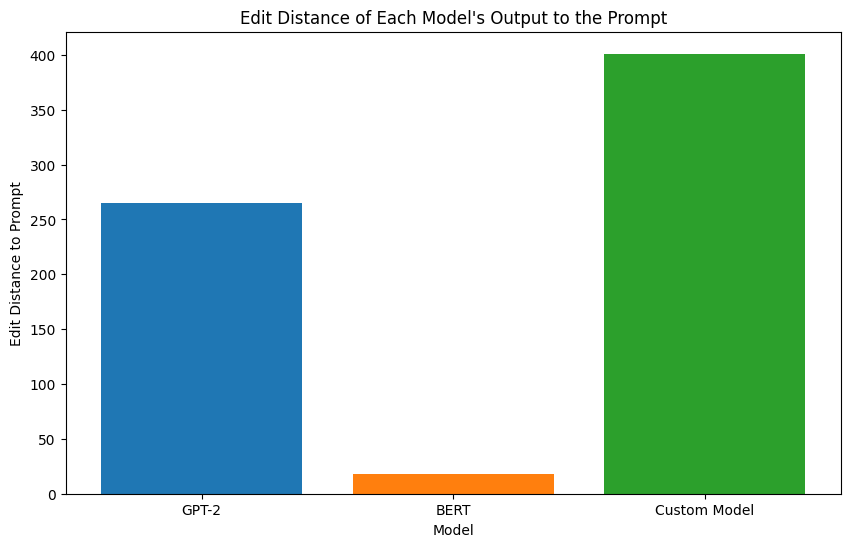

In [36]:
from nltk.metrics.distance import edit_distance
import matplotlib.pyplot as plt
import pandas as pd

prompt_text = "He wakens in Ithaca, which he does not at first recognize. He learns from Athene, for the first time, that the wooers beset his house. She disguises him as an old man, and bids him go to the hut of the swineherd Eumaeus, who is loyal to his absent lord. Athene then goes to Lacedaemon, to bring back Telemachus, who has now resided there for a month. Odysseus won the heart of Eumaeus, who of course did not recognize him, and slept in the swineherd's hut, while Athene was waking Telemachus in Lacedaemon and bidding him 'be mindful of his return.'"

#models text
gpt2_text = "He wakens in Ithaca, which he does not at first recognize. He learns from Athene, for the first time, that the wooers beset his house. She disguises him as an old man, and bids him go to the hut of the swineherd Eumaeus, who is loyal to his absent lord. Athene then goes to Lacedaemon"
bert_text = "He wakens in Ithaca , which he does not at first recognize . He learns from Athene , for the first time , that the wooers beset his house . She disguises him as an old man , and bids him go to the hut of the swineherd Eumaeus , who is loyal to his absent lord . Athene then goes to Lacedaemon , to bring back Telemachus , who has now resided there for a month . Odysseus won the heart of Eumaeus , who of course did not recognize him , and slept in the swineherd ' s hut , while Athene was waking Telemachus in Lacedaemon and bidding him be mindful of his return. "
#I chose random search
custom_text = "that has grown too much , jack answered , when he had grown fat and thin silk ; he looks so strangely , and his horns are ; but he fears and ugly - looking . \' i don \' t tell him now . hin - bsockle ! \' s every man with the rain , like these shoes off , with one feather bed . he needs brave a drum of pale melut tree , the same falling in levies , but the man , enduring him food , tell him , loveo , with his golden hulls , laugh and offers a gro . the boy"

#distances
dist_prompt_gpt2 = edit_distance(prompt_text, gpt2_text)
dist_prompt_bert = edit_distance(prompt_text, bert_text)
dist_prompt_custom = edit_distance(prompt_text, custom_text)

distance_data = pd.DataFrame({
    'Model': ['GPT-2', 'BERT', 'Custom Model'],
    'Edit Distance': [dist_prompt_gpt2, dist_prompt_bert, dist_prompt_custom]
})

#plotting
plt.figure(figsize=(10, 6))
plt.bar(distance_data['Model'], distance_data['Edit Distance'], color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.xlabel("Model")
plt.ylabel("Edit Distance to Prompt")
plt.title("Edit Distance of Each Model's Output to the Prompt")
plt.show()


Interpretation of experiment and results:
Overview of the experiment I chose Google's BERT model and Chatgpt2 as they seemed like solid and balanced models for prompt generation. I followed the tutorial and I had to use colab as trying Rivanna and locally at first did not work with the dependencies and version of tf and keras.

After creating the original model and seeing the prompt generation shown by the tutorial it seemed like this model created a lot of non sense text. I then used the pre trained models, gpt2 and BERT with comparison to a custom prompt. The prompt I chose was a snippet of the Odyssey. I then generated text using the original model, gpt2, and BERT. I then did edit distance evaluation to compare how they faired from the original prompt, learned from NLP course at UVA. At it appeared that the custom model performed the worst as it had the most dissimilar text output from the prompt, gpt2 was second best, and BERT was very close to the content of the prompt.